In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.3, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t

path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/01 Rock Shuffle 130BPM
  01 8th Toms.mid
  02 8th Hat.mid
  03 8th Cym.mid
  04 4th Cym.mid
  05 12th Hat.mid
  06 4th Hat.mid
  07 12th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/02 Rock Tribal 125BPM
  01 4th Toms.mid
  02 16th Hat.mid
  03 4th Toms.mid
  04 8th Cym.mid
  05 2th Toms.mid
  06 16th Hat.mid
  07 16th Cym.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/03 Moon 137BPM
  01 8th Cym.mid
  02 8th Hat.mid
  03 8th Cym.mid
  04 2th Toms.mid
  05 4th Cym.mid
  06 16th Hat.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/04 Titanic 97BPM
  01 8th Hat.mid
  02 16th Hat.mid
  03 4th Cym.mid
  04 8th Cym.mid
  05 8th Hat.mid
  06 8th Toms.mid
  07 16th Cym.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/05 Halftime 71BPM
  01 16th Hat.mid
  02 16th Cym.mid
  03 16th Perc.mid
  04 16th Cym.mid
  05 16th Toms.mid
  06 16th Ride.mid
  

In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
# [(i,k) for i,k in enumerate(labels)]

In [8]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
"""Genre dict = for classes
Label dict = for unique samples
"""
genre_dict = setup.build_label_dict(genres)
labels_ = [label.split('/') for label in labels]
label_dict = setup.build_label_dict(labels_, min_samples=1)

In [9]:
n_samples_per_genre = [len(items) for items in genre_dict.values()]
for f in [min, max, np.mean, np.median]:
    print(f, f(n_samples_per_genre))
n_genres = len(n_samples_per_genre)
print(n_genres)

<built-in function min> 7
<built-in function max> 7
<function mean at 0x104d8cf28> 7.0
<function median at 0x104ec1d08> 7.0
71


In [10]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [11]:
latent_dim = 10
epsilon_std = 1.0
batch_size = 128
epochs = 500

name = 'non-functional_model.h5'
fn = config.model_dir + name

In [12]:
vae, encoder, generator = models.build(input_shape, latent_dim)
vae.load_weights(fn)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


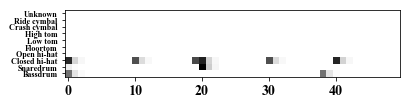

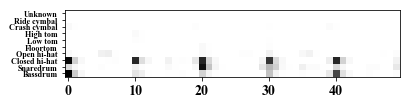

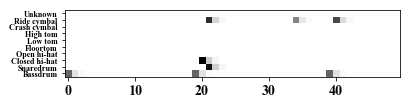

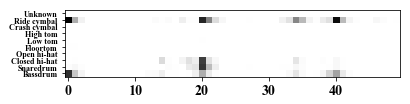

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [13]:
i,j = 0, 10
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

## NCD evaluation

In [14]:
dn = config.plots_dir
best_dims = io.load(dn + 'transformations-best_dims.pkl')
transformations = io.load(dn + 'transformations.pkl')
min_transformations = io.load(dn + 'min_transformations.pkl')
len(list(transformations.keys()))

71

(array([631., 134., 177.,  50., 112., 148., 247.,  77.,  91., 333.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

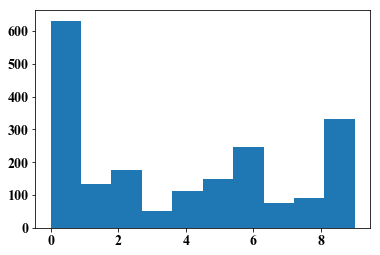

In [15]:
plt.hist(best_dims)

In [16]:
m = 500
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(500, 10)

In [17]:
# utils.reload(ncd_evaluation)
grid = [0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 1, 0, -0.01, -0.1, -0.5, -1]
grid = np.linspace(0,1, 21)
# grid = (np.logspace(0, 1, 10) -1) / 9
# grid = np.round(grid, 2)
amt1 = None
amt2 = None
grid

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [18]:
# different_genre_a = True
# result_min = ncd_evaluation.cross(x_train_encoded, genre_dict, min_transformations, 
#                                   generator, grid, different_genre_a, amt1=amt1, amt2=amt2, v=1)
# io.save(result_min, config.plots_dir + 'ncd_evaluation_ABC_min.pkl')

In [19]:
# result = ncd_evaluation.cross(x_train_encoded, genre_dict, transformations, 
#                               generator, grid, different_genre_a, amt1=amt1, amt2=amt2, v=0)
# io.save(result, config.plots_dir + 'ncd_evaluation_ABC.pkl')

In [33]:
utils.reload(ncd_evaluation)
different_genre_a = False
result_AB_min = ncd_evaluation.cross(x_train_encoded, genre_dict, min_transformations, 
                                     generator, grid, different_genre_a, amt1=amt1, amt2=amt2, v=2)
print(len(list(result_AB_min.keys())))
io.save(result_AB_min, config.plots_dir + 'ncd_evaluation_AB_min.pkl')

different_genre_a = False

original genre: `01 Rock'n'Roll/01 Dancin Rick 166BPM`
 genre_a=01 Rock'n'Roll/01 Dancin Rick 166BPM
 genre_a `01 Rock'n'Roll/01 Dancin Rick 166BPM`, 2
 - genre_b `07 Indie/10 Chilled 120BPM`
 - genre_b `04 Country/10 Rough Rider 183BPM`

original genre: `01 Rock'n'Roll/02 Gogo 191BPM`
 genre_a=01 Rock'n'Roll/02 Gogo 191BPM
 genre_a `01 Rock'n'Roll/02 Gogo 191BPM`, 2
 - genre_b `07 Indie/04 Titanic 97BPM`
 - genre_b `03 Traditional Pop/01 Fly High 115BPM`

original genre: `01 Rock'n'Roll/03 Lips n Hips 152BPM`
 genre_a=01 Rock'n'Roll/03 Lips n Hips 152BPM
 genre_a `01 Rock'n'Roll/03 Lips n Hips 152BPM`, 2
 - genre_b `06 Soul - Funk/06 JB Groove 115BPM`
 - genre_b `05 Jazz/10 Scalis 190BPM 3-4`

original genre: `01 Rock'n'Roll/04 Maybelline 233BPM`
 genre_a=01 Rock'n'Roll/04 Maybelline 233BPM
 genre_a `01 Rock'n'Roll/04 Maybelline 233BPM`, 2
 - genre_b `03 Traditional Pop/02 Frankies Girl 116BPM`
 - genre_b `06 Soul - Funk/01 Soul Groove 107BPM`

original genr


original genre: `04 Country/06 Booker 170BPM`
 genre_a=04 Country/06 Booker 170BPM
 genre_a `04 Country/06 Booker 170BPM`, 2
 - genre_b `04 Country/09 Broonze 122BPM`
 - genre_b `01 Rock'n'Roll/01 Dancin Rick 166BPM`

original genre: `04 Country/07 Trainy 100BPM`
 genre_a=04 Country/07 Trainy 100BPM
 genre_a `04 Country/07 Trainy 100BPM`, 2
 - genre_b `03 Traditional Pop/09 Distel 155BPM`
 - genre_b `05 Jazz/10 Scalis 190BPM 3-4`

original genre: `04 Country/08 Eddie Ed 111BPM`
 genre_a=04 Country/08 Eddie Ed 111BPM
 genre_a `04 Country/08 Eddie Ed 111BPM`, 2
 - genre_b `07 Indie/08 Bouncer 162BPM`
 - genre_b `02 Blues/01 Booze 92BPM`

original genre: `04 Country/09 Broonze 122BPM`
 genre_a=04 Country/09 Broonze 122BPM
 genre_a `04 Country/09 Broonze 122BPM`, 2
 - genre_b `05 Jazz/09 West Coast 152BPM Brushes`
 - genre_b `03 Traditional Pop/01 Fly High 115BPM`

original genre: `04 Country/10 Rough Rider 183BPM`
 genre_a=04 Country/10 Rough Rider 183BPM
 genre_a `04 Country/10 Rough Ri

'../results/ncd_evaluation_AB_min.pkl'

In [34]:
different_genre_a = False
result_AB = ncd_evaluation.cross(x_train_encoded, genre_dict, transformations, 
                                 generator, grid, different_genre_a, amt1=amt1, amt2=amt2, v=0)
print(len(list(result_AB.keys())))
io.save(result_AB, config.plots_dir + 'ncd_evaluation_AB.pkl')

71


'../results/ncd_evaluation_AB.pkl'

### One to one transformations

In [ ]:
# dn = config.plots_dir
# # best_dims = io.load(dn + 'transformations-one-to-one-best_dims.pkl')
# transformations = io.load(dn + 'transformations-one-to-one.pkl')
# min_transformations = io.load(dn + 'min_transformations-one-to-one.pkl')

In [ ]:
# utils.reload(ncd_evaluation)
# different_genre_a = False
# result = ncd_evaluation.cross(x_train_encoded, label_dict, min_transformations, 
#                 generator, grid, different_genre_a, amt1=amt1, amt2=1, v=1)
# io.save(result, config.plots_dir + 'ncd_evaluation-one-to-one_AB_min.pkl')

In [ ]:
# result = ncd_evaluation.cross(x_train_encoded, label_dict, transformations, 
#             generator, grid, different_genre_a, amt1=amt1, amt2=1, v=0)
# io.save(result, config.plots_dir + 'ncd_evaluation-one-to-one_AB.pkl')